<a href="https://colab.research.google.com/github/Team-AlmaBetter/Retail-Sales-Prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

#<b>Import necessary libraries

In [42]:
!pip install chart_studio
import pandas as pd, datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot
from matplotlib.pyplot import *
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

# <b>2.Data Preparation

##<b>2.1 Import Datasets

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
R_data = pd.read_csv('/content/drive/MyDrive/Retail Sales- Capstone 2/Data & Resources/Rossmann Stores Data.csv')
R_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
R_data.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [ ]:
R_data.shape

(1017209, 9)

In [45]:
store = pd.read_csv('/content/drive/MyDrive/Retail Sales- Capstone 2/Data & Resources/store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [ ]:
store.shape

(1115, 10)

#<B>2.2 Dealing With Missing Values 

##<b>2.2.1 Count missing values in each dataset

In [46]:
print("R_data:\n\n", R_data.isnull().sum(),  
     "\n\nstore:\n\n", store.isnull().sum())

R_data:

 Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64 

store:

 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


##<b>2.2.2 Remove features with high percentages of missing values

We can see that some features have a high percentage of missing values and they won't be accurate as indicators, so we will remove features with more than 30% missing values.

In [47]:
# remove features
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceWeek',
                     'Promo2SinceYear', 'PromoInterval'], axis=1)

## 2.2.3 Replace missing values in features with low percentages of missing values

In [48]:
# check for any null values
store.isnull().sum()

Store                  0
StoreType              0
Assortment             0
CompetitionDistance    3
Promo2                 0
dtype: int64

Since Competition distance have 3 null values.
So we will fill the null values with its mean

In [49]:
# filling competition distance with mean
store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean(), inplace = True)


In [50]:
# lets check again for null value
store.isnull().sum()

Store                  0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
dtype: int64

#2.3 Date Extraction

Lets extract the dates from date features
Since we have only dates, we will extract years, months, day and weakof year

In [12]:
R_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


Firstly convert the datatype of 'Date' column to datetime format

In [51]:
# converting to datetime datatype

R_data['Date']=pd.to_datetime(R_data['Date'])


In [52]:
R_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [53]:
# extract year, month, day and week of year from "Date"
R_data['Year'] =pd.DatetimeIndex(R_data['Date']).year
R_data['Month'] =pd.DatetimeIndex(R_data['Date']).month
R_data['Day'] =pd.DatetimeIndex(R_data['Date']).day
R_data['WeekOfYear'] = pd.DatetimeIndex(R_data['Date']).weekofyear
# R_data = R_data.reset_index()

In [54]:
R_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
 9   Year           1017209 non-null  int64         
 10  Month          1017209 non-null  int64         
 11  Day            1017209 non-null  int64         
 12  WeekOfYear     1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(11), object(1)
memory usage: 100.9+ MB


# 2.4 Joining Tables

Now join the table R_data and store dataframe 

In [55]:
data = pd.merge(R_data, store, how='left', on='Store')
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,c,a,1270.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,a,a,570.0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,a,a,14130.0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,c,c,620.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,a,a,29910.0,0


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Store                1017209 non-null  int64         
 1   DayOfWeek            1017209 non-null  int64         
 2   Date                 1017209 non-null  datetime64[ns]
 3   Sales                1017209 non-null  int64         
 4   Customers            1017209 non-null  int64         
 5   Open                 1017209 non-null  int64         
 6   Promo                1017209 non-null  int64         
 7   StateHoliday         1017209 non-null  object        
 8   SchoolHoliday        1017209 non-null  int64         
 9   Year                 1017209 non-null  int64         
 10  Month                1017209 non-null  int64         
 11  Day                  1017209 non-null  int64         
 12  WeekOfYear           1017209 non-null  int64         
 1

In [ ]:
data.isnull().sum()

Store                  0
DayOfWeek              0
Date                   0
Sales                  0
Customers              0
Promo                  0
StateHoliday           0
SchoolHoliday          0
Year                   0
Month                  0
Day                    0
WeekOfYear             0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
dtype: int64

# 2.5 Drop Subsets Of Data Which Might Cause Bias

In [57]:
# We will remove the part of the datasets,where stores are closed, they won't generate sales
data=data[data.Open != 0]

In [58]:
# lets drop open column as it have no use now
data.drop('Open',axis=1,inplace=True)

In [59]:
# Check for Opened store with zero sales
data[data.Sales==0]['Store'].sum()

31460

In [60]:
# percentage of open stored with zero sales
data[data.Sales == 0]['Sales'].sum()/data.Sales.sum()

0.0

In [22]:
# Remove the Stores with zero sales
data=data[data.Sales != 0]

Checking the nominal values

In [23]:
# Nominal Values
set(data.StateHoliday),set(data.Assortment),set(data.StoreType)

({0, '0', 'a', 'b', 'c'}, {'a', 'b', 'c'}, {'a', 'b', 'c', 'd'})

Since StateHoliday have zero for none.
let's convert that into string '0'

In [24]:
# converting 0 to string '0'
data.loc[data.StateHoliday == 0,'StateHoliday'] = data.loc[data.StateHoliday == 0,'StateHoliday'].astype(str)

---
## 2.6 Feature Engineering 
---

In [61]:
# see what variable types we have
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Store                844392 non-null  int64         
 1   DayOfWeek            844392 non-null  int64         
 2   Date                 844392 non-null  datetime64[ns]
 3   Sales                844392 non-null  int64         
 4   Customers            844392 non-null  int64         
 5   Promo                844392 non-null  int64         
 6   StateHoliday         844392 non-null  object        
 7   SchoolHoliday        844392 non-null  int64         
 8   Year                 844392 non-null  int64         
 9   Month                844392 non-null  int64         
 10  Day                  844392 non-null  int64         
 11  WeekOfYear           844392 non-null  int64         
 12  StoreType            844392 non-null  object        
 13  Assortment   

In [62]:
# make a copy for me
data2 = data.copy()

In [27]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Store                844338 non-null  int64         
 1   DayOfWeek            844338 non-null  int64         
 2   Date                 844338 non-null  datetime64[ns]
 3   Sales                844338 non-null  int64         
 4   Customers            844338 non-null  int64         
 5   Promo                844338 non-null  int64         
 6   StateHoliday         844338 non-null  object        
 7   SchoolHoliday        844338 non-null  int64         
 8   Year                 844338 non-null  int64         
 9   Month                844338 non-null  int64         
 10  Day                  844338 non-null  int64         
 11  WeekOfYear           844338 non-null  int64         
 12  StoreType            844338 non-null  object        
 13  Assortment   

In [28]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Store                1115 non-null   int64  
 1   StoreType            1115 non-null   object 
 2   Assortment           1115 non-null   object 
 3   CompetitionDistance  1115 non-null   float64
 4   Promo2               1115 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 43.7+ KB


## 2.6.1 Create new variable "AvgSales" 
create a variable that calculates monthly average sales for each store

In [63]:
# calculate weekly average sales
sales = data2[['Year','Month','Store','Sales']].groupby(['Year','Month','Store']).mean()
sales = sales.rename(columns={'Sales':'AvgSales'})
sales = sales.reset_index()

In [64]:
data2['sales_key']=data2['Year'].map(str) + data['Month'].map(str) + data['Store'].map(str)
sales['sales_key']=sales['Year'].map(str) + sales['Month'].map(str) + sales['Store'].map(str)

In [65]:
# drop extra columns
sales = sales.drop(['Year','Month','Store'], axis=1)
# merge
data2 = pd.merge(data2, sales, how='left', on=('sales_key'))

In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864294 entries, 0 to 864293
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Store                864294 non-null  int64         
 1   DayOfWeek            864294 non-null  int64         
 2   Date                 864294 non-null  datetime64[ns]
 3   Sales                864294 non-null  int64         
 4   Customers            864294 non-null  int64         
 5   Promo                864294 non-null  int64         
 6   StateHoliday         864294 non-null  object        
 7   SchoolHoliday        864294 non-null  int64         
 8   Year                 864294 non-null  int64         
 9   Month                864294 non-null  int64         
 10  Day                  864294 non-null  int64         
 11  WeekOfYear           864294 non-null  int64         
 12  StoreType            864294 non-null  object        
 13  Assortment    

## 2.6.2 Create new variable "AvgCustomer" 
create a variable that calculates Monthly average number of customers for each store, becuase daily number of customer is another variable to be predicted

In [66]:
# calculate weekly average
cust = data2[['Year','Month','Store','Customers']].groupby(['Year','Month', 'Store']).mean()
cust = cust.rename(columns={'Customers':'AvgCustomer'})
cust = cust.reset_index()

data2['cust_key']=data2['Year'].map(str) + data2['Month'].map(str) + data2['Store'].map(str)
cust['cust_key']=cust['Year'].map(str) + cust['Month'].map(str) + cust['Store'].map(str)

# drop original feature Customers
data2 = data2.drop('Customers', axis=1)# drop extra columns
cust = cust.drop(['Year', 'Month', 'Store'], axis=1)

# merge
data2 = pd.merge(data2, cust, how="left", on=('cust_key'))

In [67]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 904263 entries, 0 to 904262
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Store                904263 non-null  int64         
 1   DayOfWeek            904263 non-null  int64         
 2   Date                 904263 non-null  datetime64[ns]
 3   Sales                904263 non-null  int64         
 4   Promo                904263 non-null  int64         
 5   StateHoliday         904263 non-null  object        
 6   SchoolHoliday        904263 non-null  int64         
 7   Year                 904263 non-null  int64         
 8   Month                904263 non-null  int64         
 9   Day                  904263 non-null  int64         
 10  WeekOfYear           904263 non-null  int64         
 11  StoreType            904263 non-null  object        
 12  Assortment           904263 non-null  object        
 13  CompetitionDis

## 2.6.3 Transform Variable "StateHoliday"

In [68]:
# 0 - not a state holiday; 1- is on a state holiday
data2['StateHoliday'] = data2.StateHoliday.map({'0':0, 'a':1 ,'b' : 1,'c': 1})

# drop extra columns
data2 = data2.drop(['cust_key','sales_key','Store','Date'], axis=1)

###Checking data2(merged) columns,unique values

In [69]:
data2.columns

Index(['DayOfWeek', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year',
       'Month', 'Day', 'WeekOfYear', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'AvgSales', 'AvgCustomer'],
      dtype='object')

In [71]:
data2.nunique()

DayOfWeek                  7
Sales                  21734
Promo                      2
StateHoliday               2
SchoolHoliday              2
Year                       3
Month                     12
Day                       31
WeekOfYear                52
StoreType                  4
Assortment                 3
CompetitionDistance      655
Promo2                     2
AvgSales               32639
AvgCustomer            27485
dtype: int64

In [ ]:
data2.Date.unique()#to check seperately

<B>The dataset is from 1 January 2013 to 31 July 2015 , i.e. approx. 2.5 yrs.

In [37]:
li = ["DayOfWeek" , "StateHoliday" , "SchoolHoliday"]

for i in li:
  print(i)
  print(data2[i].unique())
  print("-----------------------")

DayOfWeek
[5 4 3 2 1 7 6]
-----------------------
StateHoliday
[0 1]
-----------------------
SchoolHoliday
[1 0]
-----------------------


<b>a = public holiday, b = Easter holiday, c = Christmas, 0 = No holidays

Indicates if the (Store, Date) was affected by the closure of public schools

In [ ]:
data2.Store.nunique()

1115

#<b> Exploratory Data Analysis

###<B> 1. Average Sales & Sales percent change

In [ ]:
# Date

# Create Year and Month columns
R_data['Year']  = R_data['Date'].apply(lambda x: int(str(x)[:4]))
R_data['Month'] = R_data['Date'].apply(lambda x: int(str(x)[5:7]))

data2['Year']  = data2['Date'].apply(lambda x: int(str(x)[:4]))
data2['Month'] = data2['Date'].apply(lambda x: int(str(x)[5:7]))

# Assign Date column to Date(Year-Month) instead of (Year-Month-Day)
# this column will be useful in analysis and visualization
R_data['Date'] = R_data['Date'].apply(lambda x: (str(x)[:7]))
data2['Date'] = data2['Date'].apply(lambda x: (str(x)[:7]))

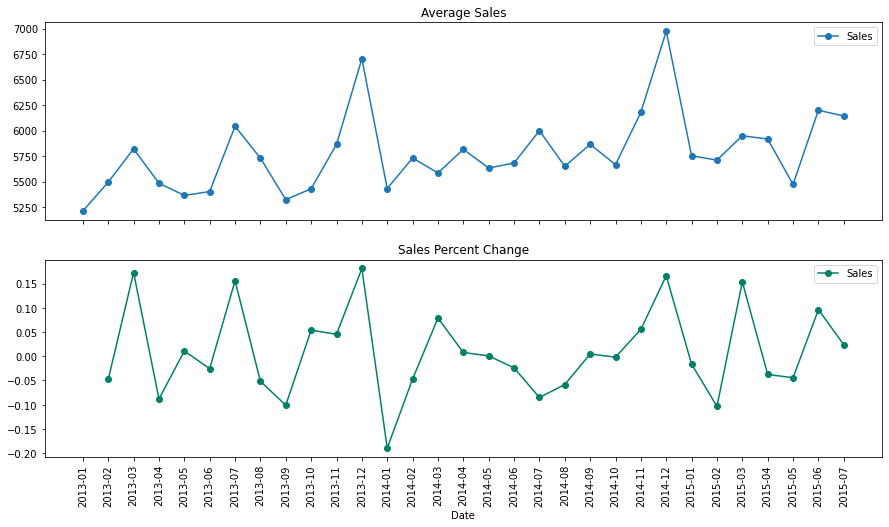

In [ ]:
# group by date and get average sales, and precent change
average_sales    = R_data.groupby('Date')["Sales"].mean()
pct_change_sales = R_data.groupby('Date')["Sales"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average sales over time(year-month)
ax1 = average_sales.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist(), rotation=90)

# plot precent change for sales over time(year-month)
ax2 = pct_change_sales.plot(legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Sales Percent Change")
# ax2.set_xticks(range(len(pct_change_sales)))
# ax2.set_xticklabels(pct_change_sales.index.tolist(), rotation=90)

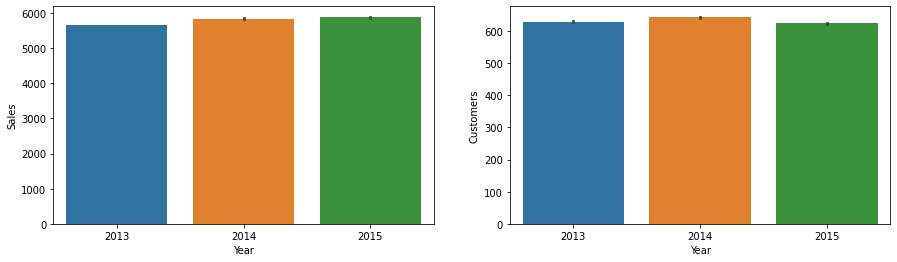

In [ ]:
# .... contiune with Date

# Plot average sales & customers for every year
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Year', y='Sales', data=R_data, ax=axis1)
sns.barplot(x='Year', y='Customers', data=R_data, ax=axis2)

# Drop Date column
# R_df.drop(['Date'], axis=1,inplace=True)
# test_df.drop(['Date'], axis=1,inplace=True)

###<B>Sales affected by SchoolHoliday or not?

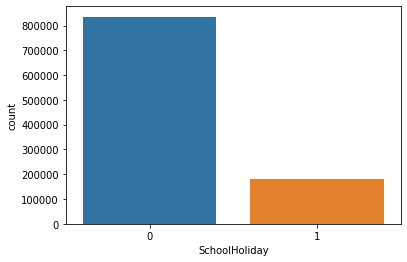

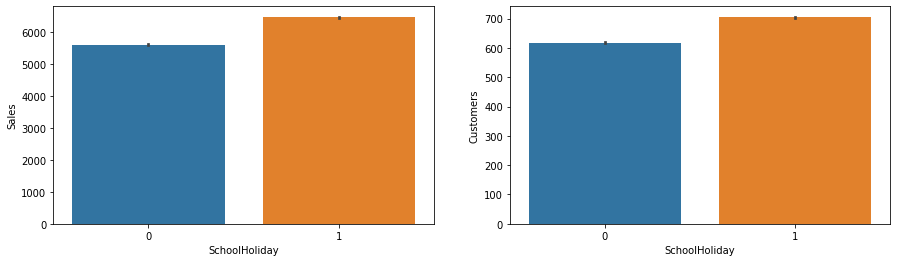

In [ ]:
# SchoolHoliday

# Plot
sns.countplot(x='SchoolHoliday', data=R_data)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='SchoolHoliday', y='Sales', data=R_data, ax=axis1)
sns.barplot(x='SchoolHoliday', y='Customers', data=R_data, ax=axis2)

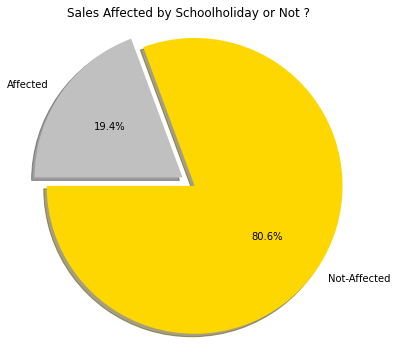

In [ ]:
labels = 'Not-Affected' , 'Affected'
sizes = data.SchoolHoliday.value_counts()
colors = ['gold', 'silver']
explode = (0.1, 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Sales Affected by Schoolholiday or Not ?")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

In [ ]:
R_data.SchoolHoliday.value_counts()

0    835488
1    181721
Name: SchoolHoliday, dtype: int64

##<B>3. Sales by StoreTypes

In [ ]:
temp = []
for i in data2.groupby('Store')[["Sales", "Customers"]].mean()["Sales"]:
  temp.append(i)
store["Sales"] = temp

In [ ]:
temp = []
for i in data2.groupby('Store')[["Sales", "Customers"]].mean()["Customers"]:
  temp.append(i)
store["Customers"] = temp

In [ ]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,Promo2,Sales,Customers
0,1,c,a,1270.0,0,4859.813848,574.035187
1,2,a,a,570.0,1,5033.684389,587.486425
2,3,a,a,14130.0,1,7049.044470,760.234892
3,4,c,c,620.0,0,9771.096154,1336.294118
4,5,a,a,29910.0,0,4768.597491,542.387685


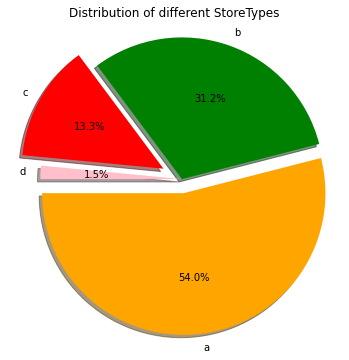

In [ ]:
labels = 'a' , 'b' , 'c' , 'd'
sizes = store.StoreType.value_counts()
colors = ['orange', 'green' , 'red' , 'pink']
explode = (0.1, 0.0 , 0.15 , 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Distribution of different StoreTypes")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

#####<b>Stores which are opened on Sundays

In [ ]:
store.isnull().sum()

Store                  0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
Sales                  0
Customers              0
dtype: int64

##<B>Correlation Heatmap

In [ ]:
corr = data2.corr()
corr

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,CompetitionDistance,Promo2,AvgSales
Store,1.000000,0.000707,0.006403,0.034618,0.001230,0.005769,0.013762,-0.011865,-0.000578,-0.009851,-0.026278,0.007000,0.010917
DayOfWeek,0.000707,1.000000,-0.178746,-0.097505,-0.288250,-0.138127,0.002176,-0.020064,0.007791,-0.013519,0.005339,-0.003216,0.001923
Sales,0.006403,-0.178746,1.000000,0.823711,0.368736,0.037992,0.036343,0.078585,-0.053065,0.079647,-0.035300,-0.126810,0.792233
Customers,0.034618,-0.097505,0.823711,1.000000,0.183486,0.025188,0.000470,0.055206,-0.036055,0.055387,-0.147733,-0.201367,0.750627
Promo,0.001230,-0.288250,0.368736,0.183486,1.000000,0.024842,0.024973,-0.003849,-0.128425,0.010305,-0.002148,-0.000454,0.001576
SchoolHoliday,0.005769,-0.138127,0.037992,0.025188,0.024842,1.000000,-0.036007,0.112947,0.035092,0.071437,-0.004204,-0.008060,-0.003476
Year,0.013762,0.002176,0.036343,0.000470,0.024973,-0.036007,1.000000,-0.260107,0.007804,-0.245893,0.000727,-0.006323,0.044736
Month,-0.011865,-0.020064,0.078585,0.055206,-0.003849,0.112947,-0.260107,1.000000,-0.008387,0.960118,0.005956,-0.025438,0.078012
Day,-0.000578,0.007791,-0.053065,-0.036055,-0.128425,0.035092,0.007804,-0.008387,1.000000,0.038836,-0.000332,0.001490,-0.002532
WeekOfYear,-0.009851,-0.013519,0.079647,0.055387,0.010305,0.071437,-0.245893,0.960118,0.038836,1.000000,0.005715,-0.024423,0.064981


Text(0.5, 1.0, 'Correlation Heatmap')

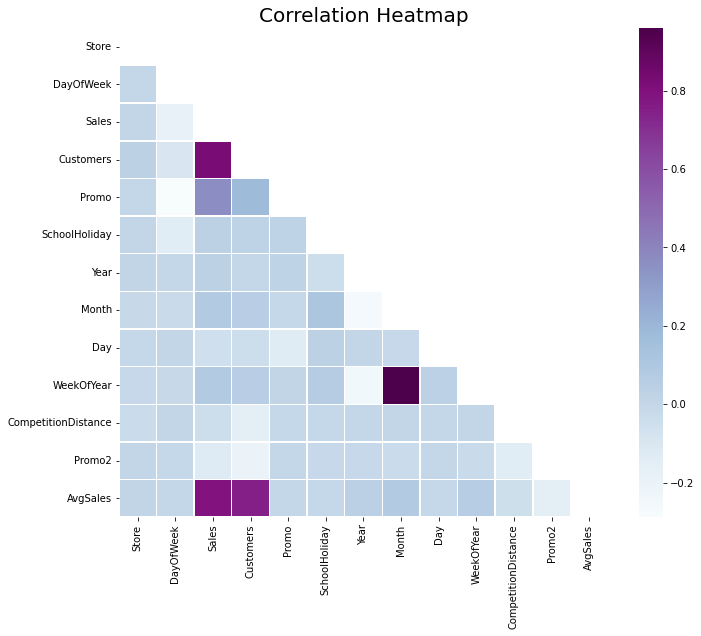

In [ ]:
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (11, 9))
# sns.heatmap(corr, mask = mask,square = True, linewidths = .5, ax = ax, cmap = "BuPu")
sns.heatmap(corr,square = True,mask=mask, linewidths = .5,ax=ax, cmap = "BuPu")
plt.title("Correlation Heatmap", fontsize=20)

# **4. Sales by Season**

In [72]:
# Create new column Season

data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format = True)

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Quarter'] = data['Date'].dt.quarter
data['Week'] = data['Date'].dt.week
data['Day'] = data['Date'].dt.day

data['Season'] = np.where(data['Month'].isin([3,4,5]), "Spring",
                 np.where(data['Month'].isin([6,7,8]), "Summer",
                 np.where(data['Month'].isin([9,10,11]), "Fall",
                 np.where(data['Month'].isin([12,1,2]), "Winter", "None"))))

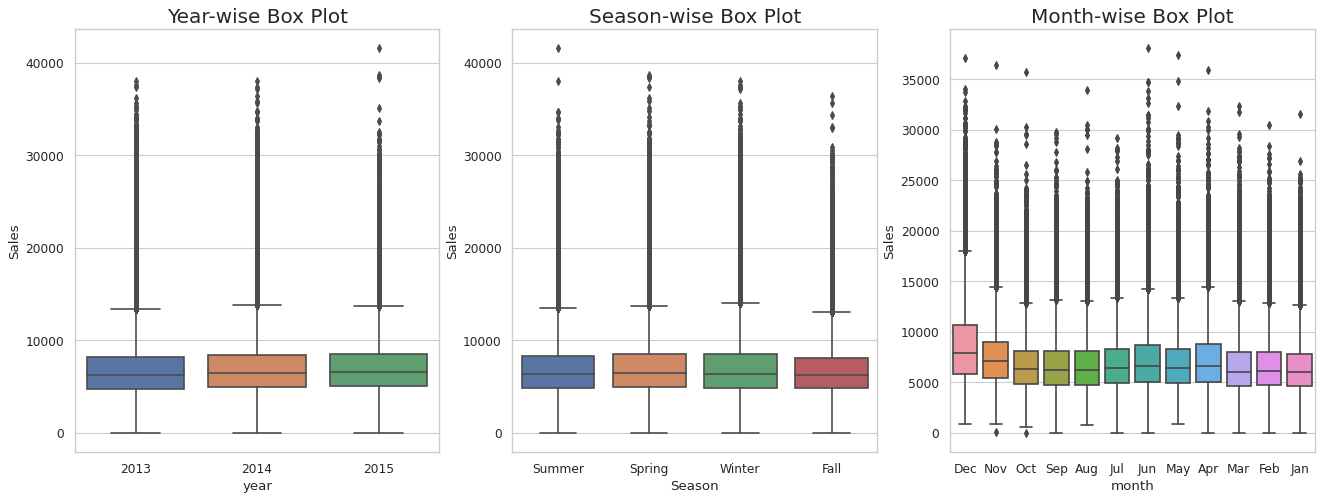

In [83]:
# Prepare data
data['year'] = [d.year for d in data.Date]
data['month'] = [d.strftime('%b') for d in data.Date]
years = data['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 3, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Sales', data=data, ax=axes[0])
sns.boxplot(x='month', y='Sales', data=data.loc[~data.year.isin([2013, 2015]), :])
sns.boxplot(x='Season', y='Sales', data=data, ax=axes[1])

# Set Title
axes[0].set_title('Year-wise Box Plot', fontsize=18)
axes[1].set_title('Season-wise Box Plot', fontsize=18)
axes[2].set_title('Month-wise Box Plot', fontsize=18)
plt.show()

In [ ]:
# Cell will not run as columns dropped already



# What happened to the average sales of a store over time when competition started?
# Example: the average sales for store_id = 6 has dramatically decreased since the competition started

store_id = 6
store_data = R_data[R_data["Store"] == store_id]

average_store_sales = store_data.groupby('Date')["Sales"].mean()

# Get year, and month when Competition started
y = store["CompetitionOpenSinceYear"].loc[store_df["Store"]  == store_id].values[0]
m = store["CompetitionOpenSinceMonth"].loc[store_df["Store"] == store_id].values[0]

# Plot 
ax = average_store_sales.plot(legend=True,figsize=(15,4),marker='o')
ax.set_xticks(range(len(average_store_sales)))
ax.set_xticklabels(average_store_sales.index.tolist(), rotation=90)

# Since all data of store sales given in rossmann_df starts with year=2013 till 2015,
# So, we need to check if year>=2013 and y & m aren't NaN values.
if y >= 2013 and y == y and m == m:
    plt.axvline(x=((y-2013) * 12) + (m - 1), linewidth=3, color='grey')




# Risk Analysis
# Analyze the risk of a store; Risk(std) Vs Expected(mean)

# .... countiue using data2
store_average = R_data["Sales"].mean()
store_std     = R_data["Sales"].std()

# Plot
plt.scatter(store_average, store_std,alpha = 0.5,s =np.pi*20)

# Get min & max mean and std of store sales

std_sales = R_data.groupby('Store')["Sales"].std()

min_average = R_data["Sales"].min()
max_average = R_data["Sales"].max()
min_std     = std_sales.min()
max_std     = std_sales.max()

# Set the x and y limits of the plot
plt.ylim([min_std, max_std])
plt.xlim([min_average, max_average])

# Set the plot axis titles
plt.xlabel('Expected Sales')
plt.ylabel('Risk')

# Set label
label, x, y = "Store {}".format(store_id), store_average, store_std
plt.annotate(
        label, 
        xy = (x, y), xytext = (50, 50),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=-0.3'))

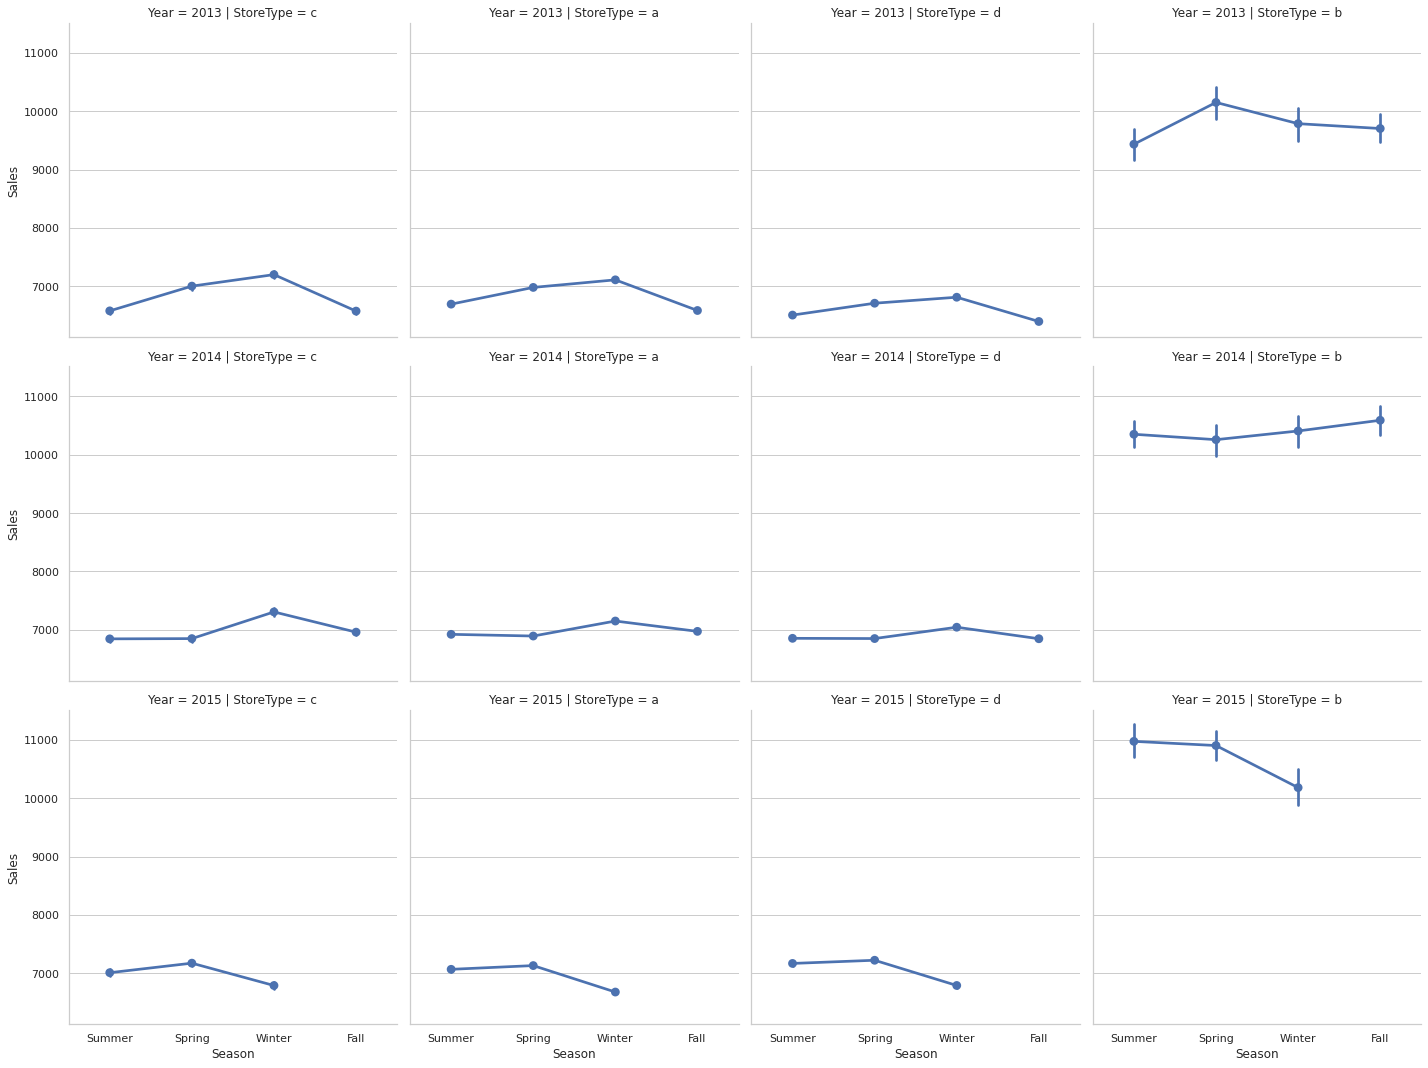

In [92]:
# Sales trend over the seasons and year
sns.factorplot(data = data, x ="Season", y = "Sales", 
               col = 'StoreType',
               row = "Year")

# **5. Affect of Promotion on sales**

Text(0.5, 1.0, 'Effect of sales after second promotion')

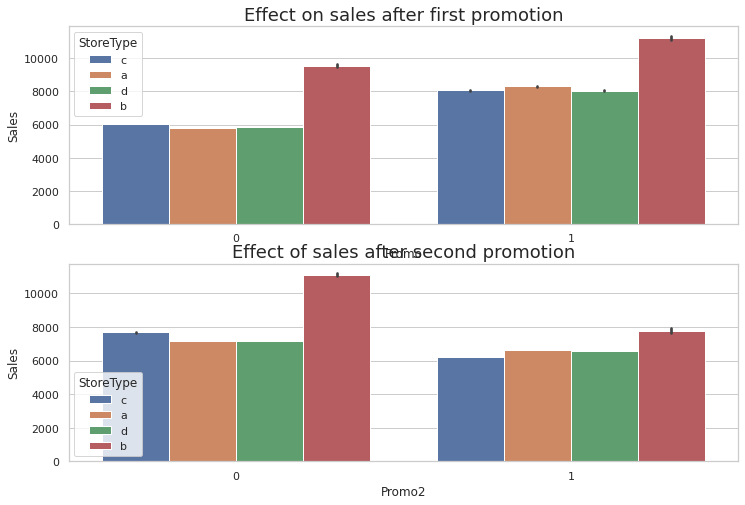

In [110]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(12,8)
sns.barplot(x= "Promo", y= "Sales", data=data2 ,hue="StoreType", ax=axes[0])
sns.barplot(x= "Promo2", y= "Sales", data=data2 ,hue="StoreType", ax=axes[1])
axes[0].set_title('Effect on sales after first promotion', fontsize=18)
axes[1].set_title('Effect of sales after second promotion', fontsize=18)

First promotion have positive effect on sales, but second promotion has negative impact on sales.